In [1]:
import random
import pandas as pd

from loguru import logger
import sys
logger.remove()
logger.add(sys.stderr, level="SUCCESS")

import itertools
from dataclasses import dataclass, field
from typing import List, Optional, Tuple
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.style.use('dark_background')

import plotly.graph_objects as go

In [2]:
RANKS = {1: 'A', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: 'J', 9: 'Q', 10: 'K'}
SUITS = {'P': '♠', 'F': '♣', 'D': '♢', 'C': '♡'}


@dataclass
class Card:    
    rank: int
    suit: str
        
    def __repr__(self):
        return f"{RANKS[self.rank]}{SUITS[self.suit]}"
    
    def __eq__(self, other):
        return self.rank == other.rank and self.suit == other.suit
    
    def __lt__(self, other):
        _SUITS = list(SUITS.keys())
        return (
            self.rank < other.rank or 
            (self.rank == other.rank and _SUITS.index(self.suit) < _SUITS.index(other.suit))
        )
    
    def __hash__(self):
        return hash(self.__repr__())
    
def make_cards():
    return [Card(rank, suit) for suit in SUITS for rank in RANKS]
        
@dataclass        
class Deck:    
    cards: List[Card] = field(default_factory=make_cards)
    
    def __len__(self):
        return len(self.cards)
    
    def __getitem__(self, position):
        return self.cards[position]
    
    def shuffle(self):
        random.shuffle(self.cards)

class Player:
    
    def __init__(self, name: str):        
        self.name = name
        self.reset()
        
    def reset(self):
        self.hand = []
        self.loot = []
        self.scope = 0        
        
    def __repr__(self):
        return f"{self.name}"
    
    def get_options(self, table):
        return {
            combo: sum(card.rank for card in combo)
            for combo in filter(
                lambda x: 0 < sum(card.rank for card in x) and sum(card.rank for card in x) <= 10, 
                itertools.chain.from_iterable(itertools.combinations(table, r) for r in range(len(table) + 1))
            )}
    
    def choose_card(self):
        random.shuffle(self.hand)
        return self.hand.pop()        
        
    def play(self, table: list):        
        _options = self.get_options(table)
        chosen_card = self.choose_card()               
        options = {combo: value for combo, value in _options.items() if value == chosen_card.rank}
        if options:
            loot = list(list(options.keys())[0]) # migliorare il criterio di scelta...
            logger.info(f"{self.name} prende {loot} da {table} giocando {chosen_card}.")
            table = list(set(table) - set(loot))            
            self.loot.extend(loot + [chosen_card])
            if not table:
                logger.info("Scopa!")
                self.scope += 1
        else:
            table.append(chosen_card)
        return table

class Team:
    
    def __init__(self, name1: str, name2: str):
        self.players = [Player(name1), Player(name2)]
        self.score = 0
        
    def reset(self):
        for player in self.players:
            player.reset()
        
    def __len__(self):
        return len(self.players)
    
    def __getitem__(self, position):
        return self.players[position]
    
    def __repr__(self):
        return f"{self.__class__.__name__}({', '.join(player.__repr__() for player in self.players)})"
    
    def count_scope(self):
        scope = sum(player.scope for player in self.players)
        if scope:
            logger.info(f"+{scope} scope")
        return scope
    
    def compute_denari(self):
        denari = 0
        _denari = len(list(filter(lambda x: x.suit == 'D', self.loot)))
        if _denari >= 5:
            if _denari == 5:
                logger.info("Denari pari")
            elif _denari < 10:
                denari = 1
                logger.info("+1 denari")
            if _denari == 10:
                denari = 1 + 21
                logger.info("CAPPOTTO!")
        return denari
    
    def compute_settebello(self):
        settebello = 0
        if Card(7, 'D') in self.loot:
            settebello = 1
            logger.info("+1 settebello")
        return settebello        
    
    def compute_carte(self):
        carte = 0
        if len(self.loot) > 20:
            carte = 1
            logger.info("+1 carte")
        elif len(self.loot) == 20:
            logger.info("Carte pari") 
        return carte        
    
    def compute_primiera(self):
        primiera = 0
        sette = list(filter(lambda x: x.rank == 7, self.loot))
        sei = list(filter(lambda x: x.rank == 6, self.loot))
        cinque = list(filter(lambda x: x.rank == 5, self.loot))
        assi = list(filter(lambda x: x.rank == 1, self.loot))
        # implementa primiera
        return primiera
    
    def compute_score(self):
        logger.info(self)
        self.loot = self.players[0].loot + self.players[1].loot
        scope = self.count_scope()               
        carte = self.compute_carte()
        denari = self.compute_denari()        
        settebello = self.compute_settebello()        
        primiera = self.compute_primiera()
        _score = scope + carte + denari + settebello + primiera
        self.score += _score
        return _score

class Hand:
    
    def __init__(self, teams: Tuple[Team]):
        self.teams = teams
        self.reset()
    
    def reset(self):
        for team in self.teams:
            team.reset()
        self.players = list(player for team in self.teams for player in team)
        first_player = random.choice(tuple(player for player in self.teams[0]))
        second_player = random.choice(tuple(player for player in self.teams[1]))
        self.rotation = (
            first_player, 
            second_player, 
            (set(self.teams[0]) - set([first_player])).pop(),
            (set(self.teams[1]) - set([second_player])).pop()
            )
        self.deck = Deck()
        self.table = []
        self.last_looter: Optional[Player] = None
        
    def distribute_cards(self):        
        cards = self.deck.cards
        for player in self.players:
            player.hand = sorted(random.sample(cards, int(len(self.deck.cards)/len(self.players))))
            cards = tuple(set(cards) - set(player.hand))
            
    def run(self):
        self.reset()
        self.distribute_cards()
        for n in range(len(self.players[0].hand)):
            logger.info(f"Turno {n + 1}:")
            for player in self.rotation:
                _table = player.play(self.table)                
                if len(_table) < len(self.table):
                    self.last_looter_idx = self.players.index(player)
                self.table = _table
        if self.table:
            logger.info(f"{self.players[self.last_looter_idx]} pulisce il tavolo {self.table}.")
            self.players[self.last_looter_idx].loot.extend(self.table)            
            self.table = []
            
        for player in self.players:
            logger.info(f"{player.name}: {', '.join(card.__repr__() for card in player.loot)}")
        
        return {team: team.compute_score() for team in self.teams}
            
class Match:
    
    def __init__(self, team1: tuple, team2: tuple):
        self.teams2scores = {Team(*team1): 0, Team(*team2): 0}
        self.goal = 21
        self.scoreboard = pd.DataFrame(columns=[team.__repr__() for team in self.teams2scores])
        
    def run(self):
        for n in itertools.count():
            if all(score < self.goal for score in self.teams2scores.values()):
                hand = Hand(tuple(self.teams2scores.keys()))
                scores = hand.run()
                for team in self.teams2scores:
                    self.teams2scores[team] += scores[team]
                self.scoreboard.loc[n + 1, :] = [self.teams2scores[team] for team in self.teams2scores]
                logger.info(self.teams2scores)
            else:
                self.scoreboard.index.name = 'hand'
                break
                
class Tournament:
    
    def __init__(
        self, 
        team1: tuple, 
        team2: tuple,
        n_match: int = 10
        ):
        self.team1 = team1
        self.team2 = team2
        self.n_match = n_match
        self.matches = []
        
    def run(self):
        for n in tqdm(range(self.n_match), "Partite: "):
            match = Match(team1=self.team1, team2=self.team2)
            match.run()
            self.matches.append(match)
        self.scoreboard = pd.DataFrame(
            data=[len(match.scoreboard) for match in self.matches],
            columns=['hands'],
            index=range(1, self.n_match + 1)
            )

In [6]:
tournament = Tournament(
    team1=('A', 'B'), 
    team2=('C', 'D'),
    n_match=1000
)
tournament.run()

In [24]:
team = list(tournament.matches[0].teams2scores.keys())[0]
list(filter(lambda x: x.rank == 7, team.loot))

[7♢, 7♡, 7♠]

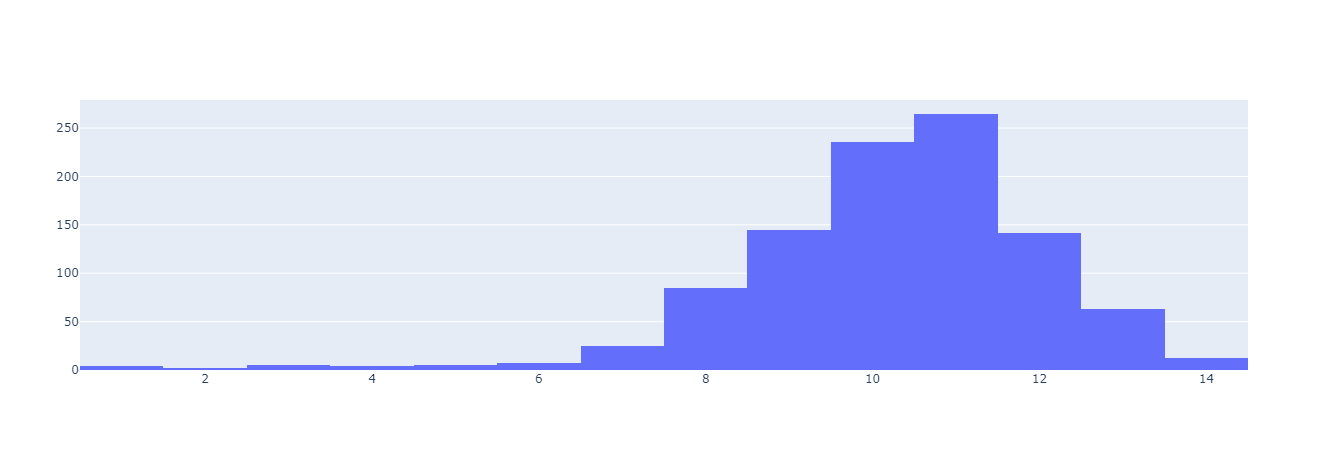

In [7]:
fig = go.Figure(
    data=[go.Histogram(x=tournament.scoreboard['hands'])]
)
fig.show()